In [259]:
library(tidyverse)
library(fda)

In [268]:
cm_k01_s19 <- read_csv("C:/Users/Personal/functional data analysis/Datos/2D_Res 32_Dom-25-10/cm_nube_k01_s19.csv")
cm_k01_s59 <- read_csv("C:/Users/Personal/functional data analysis/Datos/2D_Res 32_Dom-25-10/cm_nube_k01_s59.csv")

Parsed with column specification:
cols(
  `Time CMX1 CMY1 CMX2 CMY2 CMX3 CMY3` = col_character()
)
Parsed with column specification:
cols(
  `Time CMX1 CMY1 CMX2 CMY2 CMX3 CMY3` = col_character()
)


In [269]:
cm_k01_s19 <- cm_k01_s19 %>% mutate(Time = round(Time, 2))
cm_k01_s59 <- cm_k01_s59 %>% mutate(Time = round(Time, 2))

cm_k01 <- inner_join(cm_k01_s19, cm_k01_s59, by = 'Time', suffix = c('_sig16', '_sig56'))

ERROR: Error in mutate_impl(.data, dots): Column `Time` must be length 501 (the number of rows) or one, not 251


In [263]:
# Padding matrix to avoid problems at the boundary
paddMin <- -10
paddSize <- 10/0.1 # sample at the same rate as on the data set

paddingMat <- matrix(rep(as.matrix(cm_k01[1, ]) , each = paddSize), nrow = paddSize, ncol=dim(cm_k01)[2])
padding <- data.frame(paddingMat) 
names(padding) <- names(cm_k01)
padding <- padding %>% mutate(Time = seq(paddMin, -1, length.out = paddSize))

cm_k01 <- rbind(padding, cm_k01)

In [264]:
# Use test data to learn the n_basis param. 
trainIndex <- seq(1, dim(cm_k01)[1], by = 2)
ntrain <- length(trainIndex)

cm_k01_train <- cm_k01 %>% slice(trainIndex)
cm_k01_test <- cm_k01 %>% slice(-trainIndex)

## Choosing a basis

We'll use b-splines of order 6 since we are interested in the acceleration of the data. The basis will have ~6*2 basis elements. More elements could be used if we smooth using a penalty. 

There are some problems at the boundaries. It would be nice to have some extra time before the wave crashes into the cloud (will do this: in fact all the values are the same as at t=0 before the shock).

In [265]:
# basis 
basis13 <- create.bspline.basis(c(paddMin,40), 15, 6)

In [266]:
Time <- cm_k01_train$Time
cmMatrix <- as.matrix(cm_k01_train %>% select(-Time))
index <- seq(1, 12, by = 2)
cmxMatrix <- cmMatrix[, index]
cmyMatrix <- cmMatrix[, -index]

In [267]:
smoothCMx <- smooth.basis(argvals = Time, y = cmxMatrix, basis13)
smoothCMy <- smooth.basis(argvals = Time, y = cmyMatrix, basis13)

coefCMx <- smoothCMx$fd$coefs
coefCMy <- smoothCMy$fd$coefs

In [217]:
# Evaluating the basis functions on the Time vector. 
basisMat13 <- eval.basis(evalarg = Time, basisobj = basis13)
DbasisMat13 <- eval.basis(evalarg = Time, basisobj = basis13, Lfdobj = 2)

# Prediction
predCMx <- basisMat13 %*% coefCMx
predCMy <- basisMat13 %*% coefCMy

DDpredCMx <- DbasisMat13 %*% coefCMx
DDpredCMy <- DbasisMat13 %*% coefCMy

In [249]:
paddMax <- 50
NPindex <- (paddSize/2+1):(dim(cmxMatrix)[1])

# CMx plots with acceleration
Tracer <- rep(rep(c('cmx Cloud', 'cmx Core', 'cmx Envelope'), each=ntrain), times=2)
DDTracer <- rep(rep(c('DD(cmx) Cloud', 'DD(cmx) Core', 'DD(cmx) Envelope'), each=ntrain), times=2)

CMx_obs <- data.frame(cmxMatrix) %>% mutate(Time = Time) %>% 
                                        gather(CMx, x, -Time) %>% mutate(Tracer = Tracer)

CMx_pred <- data.frame(predCMx) %>% mutate(Time = Time) %>% 
                                        gather(CMx, x, -Time) %>% mutate(Tracer = Tracer)

DDCMx_pred <- data.frame(DDpredCMx) %>% mutate(Time = Time) %>% 
                                        gather(DDCMx, x, -Time) %>% mutate(Tracer = DDTracer)


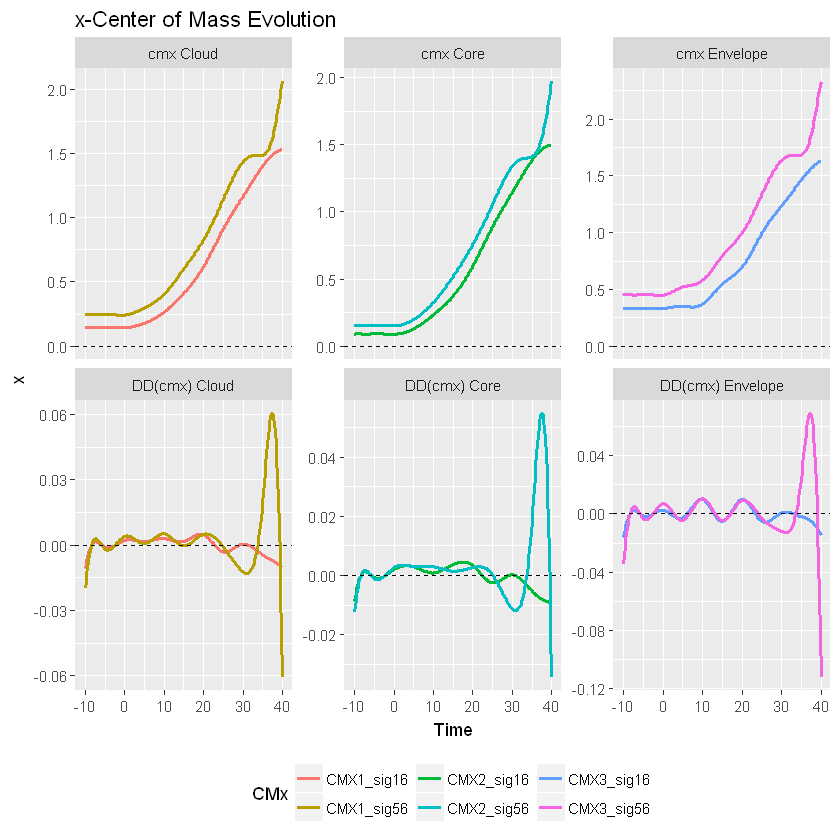

In [234]:
# to plot one at a time: CMx_pred_plot <- CMx_pred %>% filter(Sim == 3)
ggplot() + geom_line(data = CMx_pred, aes(Time, x, color=CMx), size=1) + 
            geom_line(data = DDCMx_pred, aes(Time, x, color=DDCMx), size=1) +
            geom_hline(yintercept = 0, linetype=2) +
            facet_wrap( ~ Tracer, scales="free_y", ncol=3) +
            ggtitle("x-Center of Mass Evolution") +
            theme(legend.position="bottom")

In [183]:
paddMax <- 100
NPindex <- (paddSize+1):(dim(cmxMatrix)[1] - paddMax)

In [188]:
# CMy plots with acceleration
Tracer <- rep(rep(c('cmy Cloud', 'cmy Core', 'cmy Envelope'), each=401 - paddMax), times=2)
DDTracer <- rep(rep(c('DD(cmy) Cloud', 'DD(cmy) Core', 'DD(cmy) Envelope'), each=401 - paddMax), times=2)

CMy_obs <- data.frame(cmyMatrix[NPindex, ]) %>% mutate(Time = Time[NPindex]) %>% gather(CMy, y, -Time) %>% mutate(Tracer = Tracer)
CMy_pred <- data.frame(predCMy[NPindex, ]) %>% mutate(Time = Time[NPindex]) %>% gather(CMy, y, -Time) %>% mutate(Tracer = Tracer)
DDCMy_pred <- data.frame(DDpredCMy[NPindex, ]) %>% mutate(Time = Time[NPindex]) %>% gather(DDCMy, y, -Time) %>% mutate(Tracer = DDTracer)

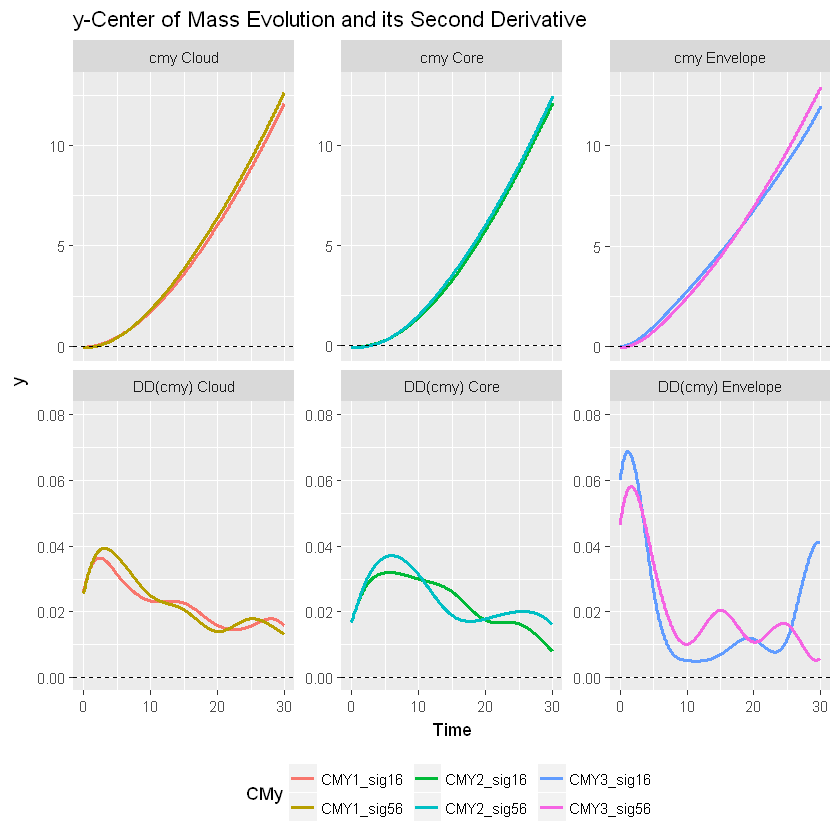

In [185]:
t12 <- c('cmy Cloud', 'cmy Core', 'cmy Envelope', 'DD(cmy) Cloud', 'DD(cmy) Core', 'DD(cmy) Envelope')
dfLimits <- data.frame(Time= rep(0,6), CMy = rep('CMY1_sig16',6), y = c(13, 13, 13, 0.08, 0.08, 0.08), Tracer = t12)

#png("cmy.png", width = 10, height = 7, units = 'in', res = 300)
ggplot() +  geom_line(data = CMy_pred, aes(Time, y, color=CMy), size=1) + 
            geom_line(data = DDCMy_pred, aes(Time, y, color=DDCMy), size=1) +
            geom_hline(yintercept = 0, linetype=2) + 
            geom_point(data = dfLimits, aes(Time, y, color=CMy), alpha=0) +
            facet_wrap( ~ Tracer, scales="free_y", ncol=3) +
            ggtitle("y-Center of Mass Evolution and its Second Derivative") +
            theme(legend.position="bottom")+
            coord_fixed(ratio = 1)

#dev.off()

In [ ]:
plotCurves <- function(CM1, CM2){
    cm_k01_plot <- cm_k01 %>% select(Time, CM1, CM2) %>% gather(Sigma, CMX, -Time)
    p <- ggplot(cm_k01_plot, aes(Time, CMX, color=Sigma)) + geom_line(size = 1)
    return(p)
}

pY1 <- plotCurves("CMY1_sig16", "CMY1_sig56")
pY2 <- plotCurves("CMY2_sig16", "CMY2_sig56")
pY3 <- plotCurves("CMY3_sig16", "CMY3_sig56")

#multiplot(pY1, pY2, pY3, cols = 1)

In [8]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}